## 3) Run optimization 

In this notebook we use the previously computed features to fit the cell model parameters and save the results.

We can run optimization on a subset of samples/feature sets.

In [1]:
%load_ext autoreload
%autoreload

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
import MEAutility as mu
import json
import numpy
import time
import numpy as np
import LFPy
from pathlib import Path
import pandas as pd

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import l5pc_model
import l5pc_evaluator

In [3]:
feature_sets = ['soma']  # ['soma', 'bap', 'extra']
sample_ids = [0] # [0, ..., n_samples]

offspring_size = 2
max_ngen = 2
channels = None

# define map_function
map_function=None

In [30]:
random_params_file = 'config/params/random.csv'
random_params = pd.read_csv(random_params_file, index_col='index')
params = random_params.iloc[0].to_dict()

In [36]:
def prepare_optimization(feature_set, sample_id, offspring_size=10, config_path='config',
                         channels=None, map_function=None):
    config_path = Path(config_path)
    morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
    param_configs = json.load(open('config/parameters.json'))
    parameters = l5pc_model.define_parameters()
    mechanisms = l5pc_model.define_mechanisms()

    cell = ephys.models.LFPyCellModel('l5pc', v_init=-65., morph=morphology, mechs=mechanisms, params=parameters)

    param_names = [param.name for param in cell.params.values() if not param.frozen]      

    if feature_set == "extra":
        probe_file = config_path / 'features' / f'random_{sample_id}' / 'probe.json'
        with probe_file.open('r') as f:
            info = json.load(f)
        probe = mu.return_mea(info=info)
        electrode = LFPy.RecExtElectrode(probe=probe)
    else:
        probe = None
        electrode = None 

    fitness_protocols = l5pc_evaluator.define_protocols(electrode=electrode) 
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=cell, cvode_active=True, electrode=electrode)

    feature_file = config_path / 'features' / f'random_{sample_id}' / f'{feature_set}.json'
    fitness_calculator = l5pc_evaluator.define_fitness_calculator(protocols=fitness_protocols, 
                                                                  feature_file=feature_file, 
                                                                  probe=probe, channels=channels)
    evaluator = ephys.evaluators.CellEvaluator(cell_model=cell, 
                                               param_names=param_names,     
                                               fitness_protocols=fitness_protocols, 
                                               fitness_calculator=fitness_calculator,     
                                               sim=sim) 
    
    opt = bpopt.optimisations.DEAPOptimisation(evaluator=evaluator,  
                                               offspring_size=offspring_size,
                                               map_function=map_function) 
    
    output = {'optimisation': opt, 'evaluator': evaluator, 'objectives_calculator': fitness_calculator,
              'protocols': fitness_protocols}
    
    return output

In [37]:
def run_optimization(feature_set, sample_id, opt, max_ngen):
    cp_filename = Path('checkpoints') /  f'random_{sample_id}' / f'{feature_set}.pkl'
    t_start = time.time()
    final_pop, halloffame, log, hist = opt.run(max_ngen=max_ngen, cp_filename=cp_filename)
    t_stop = time.time()
    print('Optimization time', t_stop - t_start)
    
    output = {'final_pop': final_pop, 'halloffame': halloffame, 'log': log, 'hist': hist}
    return output

In [ ]:
prep = prepare_optimization('extra', 1, offspring_size=offspring_size, channels=channels,
                            map_function = map_function)
opt = prep['optimisation']
evaluator = prep['evaluator']
fitness_calculator = prep['objectives_calculator']
fitness_protocols = prep['protocols']


/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)
/Users/abuccino/Documents/Codes/modeling/multimodal-fitting/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib

In [ ]:
out = run_optimization('extra', 1, opt, max_ngen=2)

In [ ]:
best_params = evaluator.param_dict(halloffame[0])
print(best_params)
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

<IPython.core.display.Javascript object>


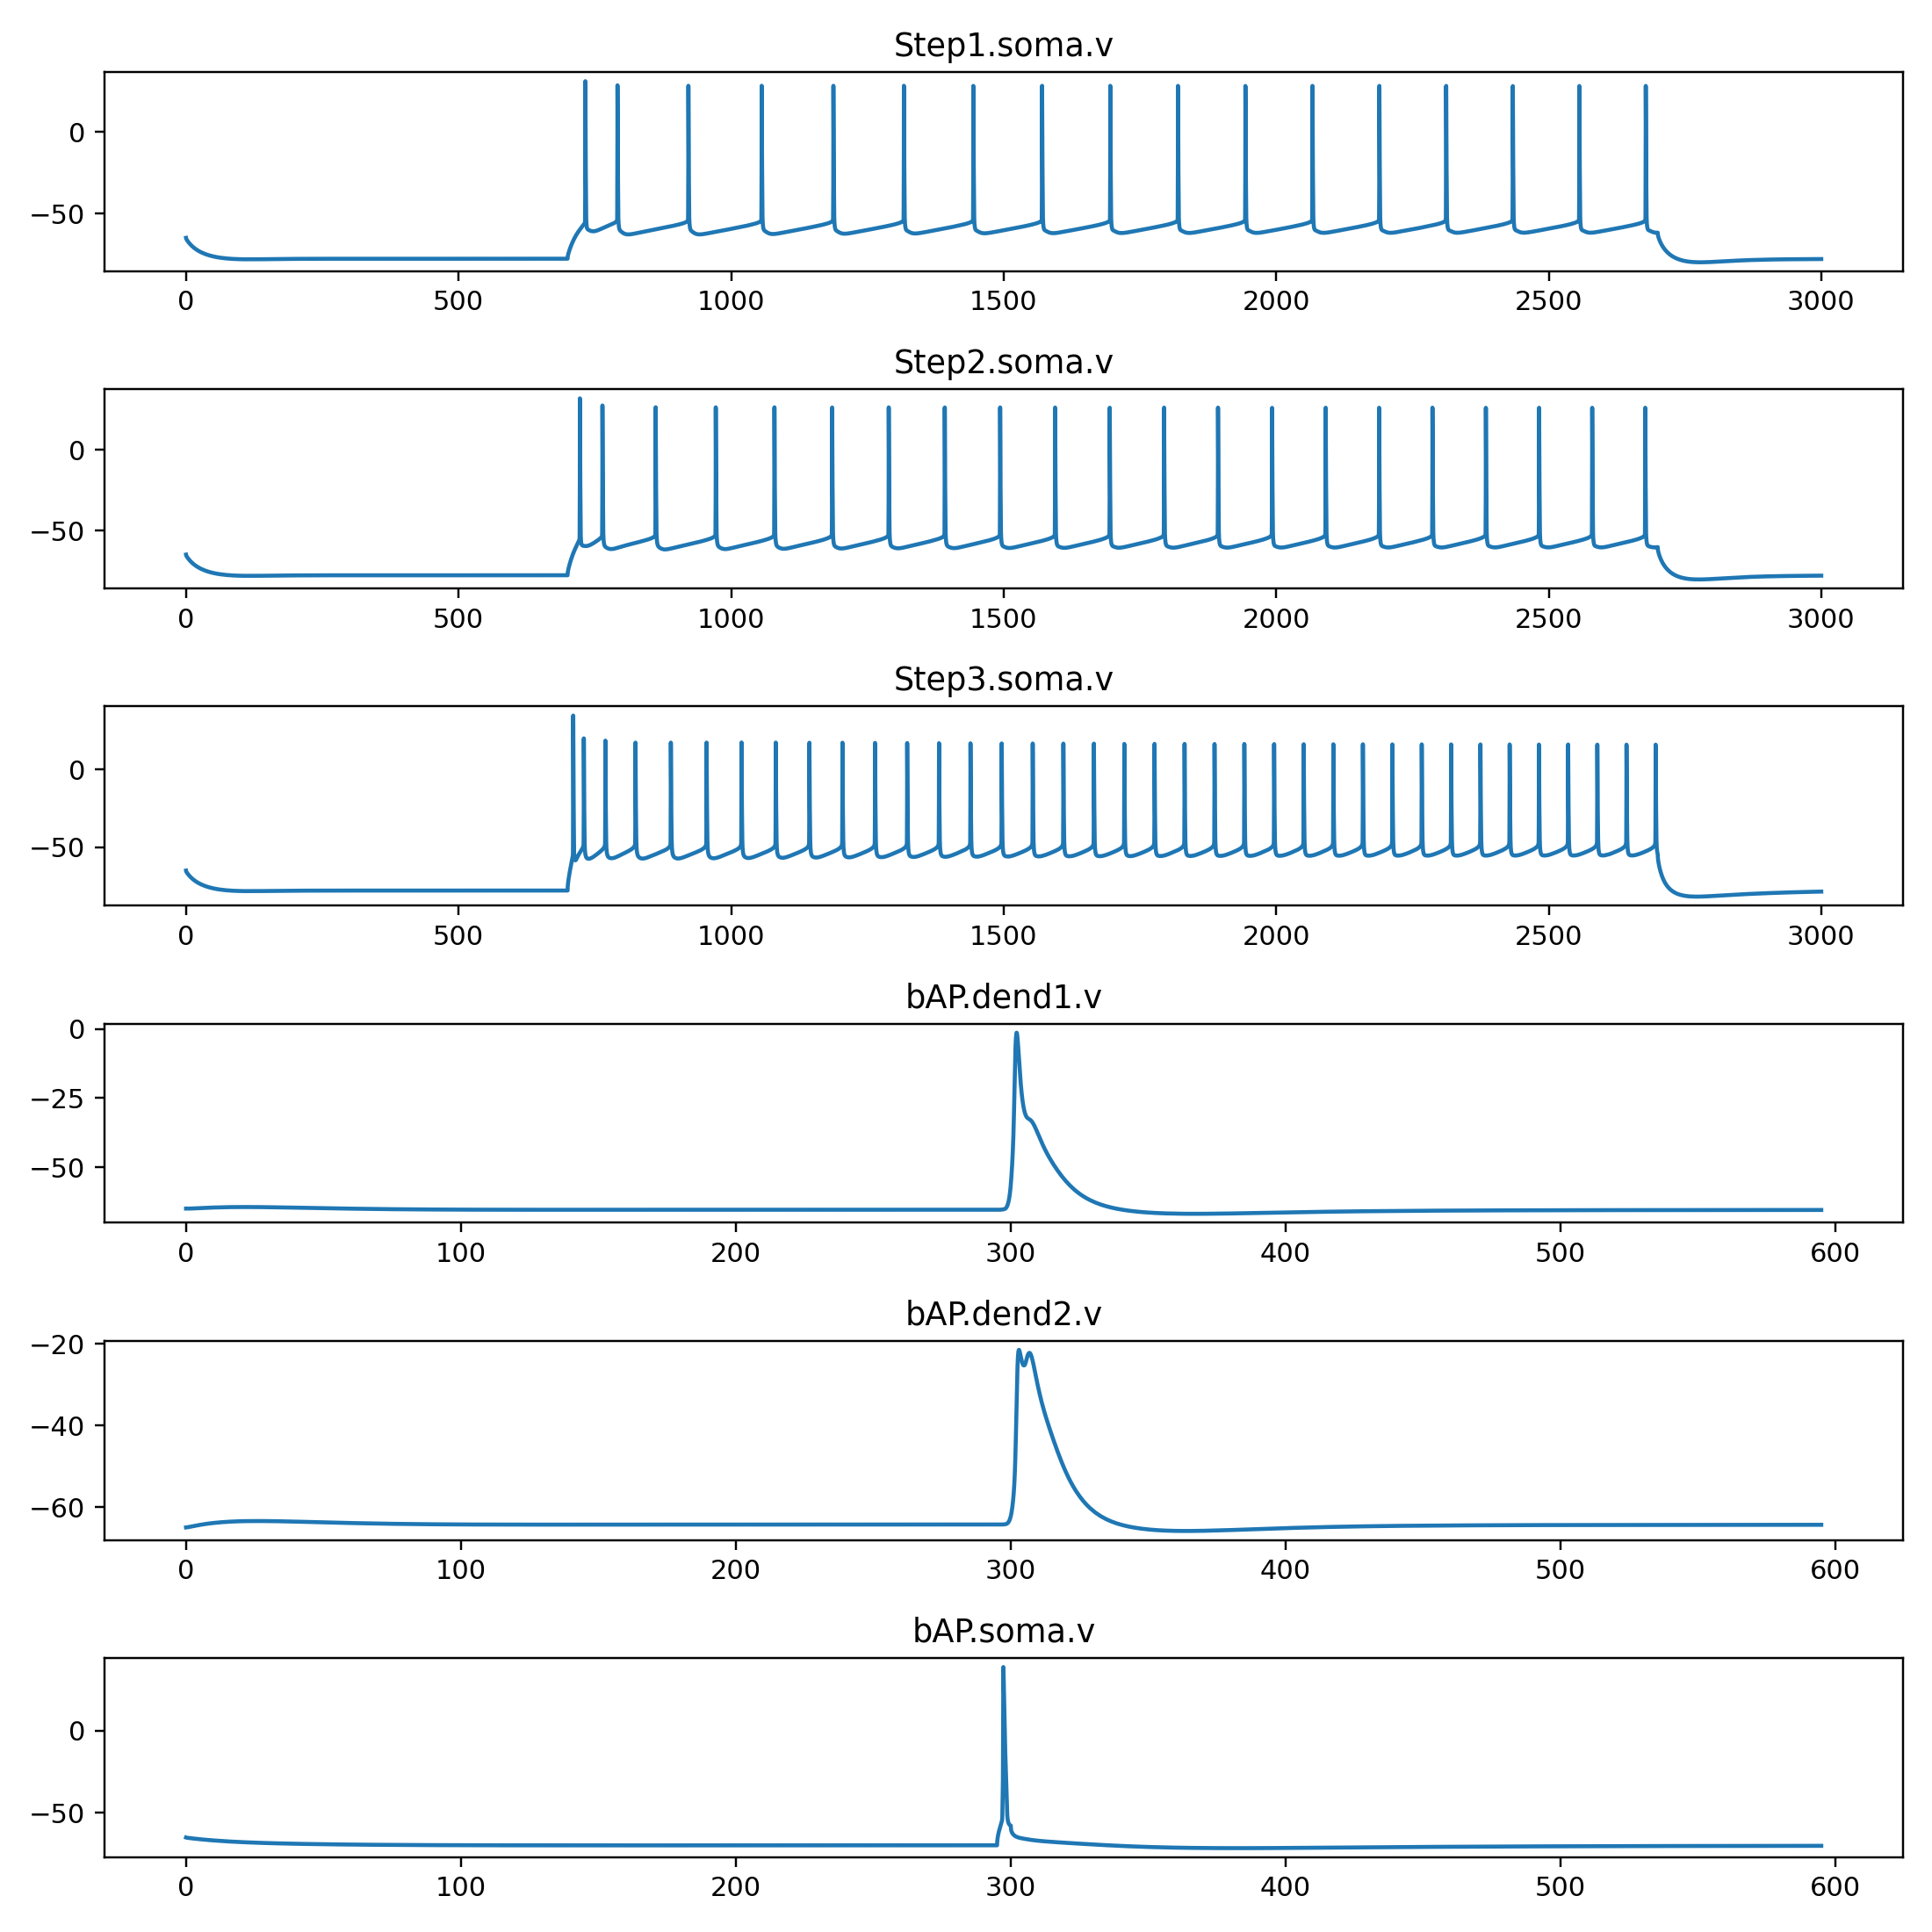

In [10]:
plot_responses(LFPy_responses)

### Visualize waveforms / features

In [ ]:
extrafeat = fitness_calculator.objectives[-1].features[0]

In [ ]:
feat, mean_wf = extrafeat.calculate_feature(LFPy_responses, return_waveforms=True)

In [ ]:
mean_wf.shape

In [ ]:
tr, pk = bpopt.ephys.extra_features_utils._get_trough_and_peak_idx(mean_wf, False)

In [ ]:
plt.figure()
cmap = plt.get_cmap('viridis')
idxs = range(0, 10)
for i, mw in enumerate(mean_wf):
    if i in idxs:
        color = cmap(i/len(mean_wf))
        plt.plot(mw / np.max(np.abs(mw)), color=color, lw=0.3)
        plt.axvline(tr[i], ls='--', color=color)
        plt.axvline(pk[i], ls='-.', color=color)

In [ ]:
mean_wf_norm = mean_wf / np.max(np.abs(mean_wf), 1, keepdims=True)
mu.plot_mea_recording(mean_wf_norm, probe)

mu.plot_mea_recording(mean_wf, probe)

### TODO: make sure all values are correct

In [ ]:
bpopt.ephys.extra_features_utils.calculate_features(mean_wf, extrafeat.fs * 1000, 
                                                    feature_names=['peak_to_valley', 'peak_trough_ratio', 'halfwidth',
                                                                   'neg_peak_relative', 'pos_peak_relative', 
                                                                   'neg_peak_diff', 'pos_peak_diff'])

In [ ]:
wf = mean_wf[3]
plt.figure()
plt.plot(wf, '*')

In [ ]:
def plot_responses(responses):
    resp_no_mea = {}
    for (resp_name, response) in sorted(responses.items()):
        if 'MEA' not in resp_name:
            resp_no_mea[resp_name] = response
        else:
            print(resp_name)
    fig, axes = plt.subplots(len(resp_no_mea), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(resp_no_mea.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()

In [ ]:
plot_responses(LFPy_responses)

In [ ]:
# plot one MEA response
plt.figure()
mea_response = LFPy_responses['Step3.MEA.LFP']
_ = plt.plot(mea_response['time'], mea_response['voltage'].T)

## Optimization

In [ ]:
offspring_size = 250
max_ngen = 100

In [ ]:
import multiprocessing

pool = multiprocessing.Pool(processes=4)

map_function = pool.map

In [ ]:
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=offspring_size,
    map_function=map_function) 

In [ ]:
t_start = time.time()
final_pop, halloffame, log, hist = opt.run(max_ngen=max_ngen, cp_filename='checkpoints/checkpoint_extra.pkl')
t_stop = time.time()
print('Optimization time', t_stop - t_start)

In [ ]:
best_params = evaluator.param_dict(halloffame[0])
print(pp.pprint(best_params))
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

In [ ]:
plot_responses(best_responses)